In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import splitfolders
from PIL import Image
from tensorflow.keras.layers import Dense, Conv2D, BatchNormalization, Dropout, Flatten, MaxPool2D, GlobalAveragePooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers

In [2]:
os.listdir("./dataset")

['cataract', 'diabetic_retinopathy', 'glaucoma', 'normal']

In [3]:
base_dir = "./dataset"
splitfolders.ratio(base_dir, output="./data", seed=42, ratio=(.8,.2))

train_dir = os.path.join("./data", "train")
val_dir = os.path.join("./data", "val")

In [4]:
def check_and_remove_corrupt_images(directory):
    for root, _, files in os.walk(directory):
        for file in files:
            try:
                img_path = os.path.join(root, file)
                img = Image.open(img_path)
                img.verify()
            except (IOError, SyntaxError, Image.UnidentifiedImageError) as e:
                print(f"File rusak ditemukan dan dihapus: {img_path}")
                os.remove(img_path)

check_and_remove_corrupt_images(train_dir)
check_and_remove_corrupt_images(val_dir)

print("Pemeriksaan dan penghapusan file rusak selesai.")

Pemeriksaan dan penghapusan file rusak selesai.


In [5]:
train_datagen = ImageDataGenerator(
    rescale=1/255.0,
    rotation_range=20,
    zoom_range=0.2,
    shear_range=0.1
)

val_datagen = ImageDataGenerator(rescale=1/255.0)

train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224,224),
    batch_size = 32,
    class_mode = "categorical"
)

val_gen = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224,224),
    batch_size = 32,
    class_mode = "categorical"
)

Found 3372 images belonging to 4 classes.
Found 845 images belonging to 4 classes.


In [6]:
reduce_on_plateau = tf.keras.callbacks.ReduceLROnPlateau(
                    monitor='val_loss', factor=0.1, patience=5, verbose=0, mode='auto',
                    min_delta=0.0001, cooldown=3, min_lr=1e-8
                )

In [7]:
model = Sequential([
    Conv2D(16, (3,3), activation="relu", input_shape=(224,224,3)),
    Conv2D(32, (3,3), activation="relu"),
    Conv2D(64, (3,3), activation="relu"),
    Flatten(),
    Dense(4, activation="softmax")
])

In [8]:
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 16)      448       
                                                                 
 conv2d_1 (Conv2D)           (None, 220, 220, 32)      4640      
                                                                 
 conv2d_2 (Conv2D)           (None, 218, 218, 64)      18496     
                                                                 
 flatten (Flatten)           (None, 3041536)           0         
                                                                 
 dense (Dense)               (None, 4)                 12166148  
                                                                 
Total params: 12,189,732
Trainable params: 12,189,732
Non-trainable params: 0
_________________________________________________________________


In [10]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='Checkpoint_Percobaan_1.keras',
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    mode='auto'
)

In [11]:

early_stop = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=10, mode='auto', baseline=None, restore_best_weights=True)

In [12]:
history = model.fit(
    train_gen,
    epochs=100,
    validation_data = val_gen,
    verbose=1,
    callbacks=[reduce_on_plateau, early_stop, checkpoint]
)

Epoch 1/100
106/106 [==============================] - ETA: 0s - loss: 2.4049 - accuracy: 0.4404
Epoch 1: val_accuracy improved from -inf to 0.50059, saving model to Checkpoint_Percobaan_1.keras
106/106 [==============================] - 63s 525ms/step - loss: 2.4049 - accuracy: 0.4404 - val_loss: 1.1450 - val_accuracy: 0.5006 - lr: 0.0010
Epoch 2/100
106/106 [==============================] - ETA: 0s - loss: 1.0707 - accuracy: 0.5495
Epoch 2: val_accuracy improved from 0.50059 to 0.63195, saving model to Checkpoint_Percobaan_1.keras
106/106 [==============================] - 58s 549ms/step - loss: 1.0707 - accuracy: 0.5495 - val_loss: 0.9367 - val_accuracy: 0.6320 - lr: 0.0010
Epoch 3/100
106/106 [==============================] - ETA: 0s - loss: 0.9131 - accuracy: 0.6311
Epoch 3: val_accuracy improved from 0.63195 to 0.69467, saving model to Checkpoint_Percobaan_1.keras
106/106 [==============================] - 56s 526ms/step - loss: 0.9131 - accuracy: 0.6311 - val_loss: 0.8400 - va

27/27 [==============================] - 6s 211ms/step - loss: 0.8197 - accuracy: 0.7112


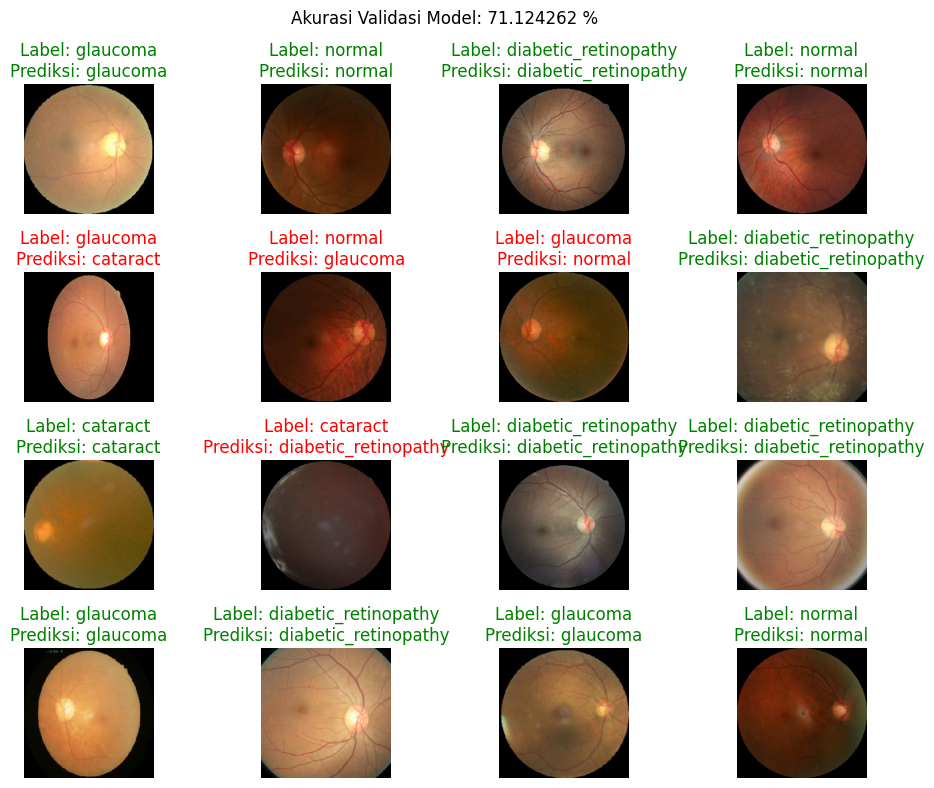

In [14]:
import numpy as np
import matplotlib.pyplot as plt

X_batch, y_batch = next(val_gen)

for img in X_batch:
    img = np.uint8(img)

preds = model.predict(X_batch)
pred_classes = np.argmax(preds, axis=1)
true_classes = np.argmax(y_batch, axis=1)

daftar_label = ["cataract", "diabetic_retinopathy", "glaucoma", "normal"]
fig, axes = plt.subplots(4, 4, figsize=(10, 8))
loss, accuracy = model.evaluate(val_gen)
fig.suptitle("Akurasi Validasi Model: %f %%" % (accuracy*100))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(X_batch[i])
    ax.axis('off')

    true_label = daftar_label[true_classes[i]]
    pred_label = daftar_label[pred_classes[i]]

    font_color = 'green' if true_label == pred_label else 'red'

    ax.set_title(f"Label: {true_label}\nPrediksi: {pred_label}", color=font_color)

plt.tight_layout()
plt.show()

In [15]:
model.save("P1_71_12persen.keras")

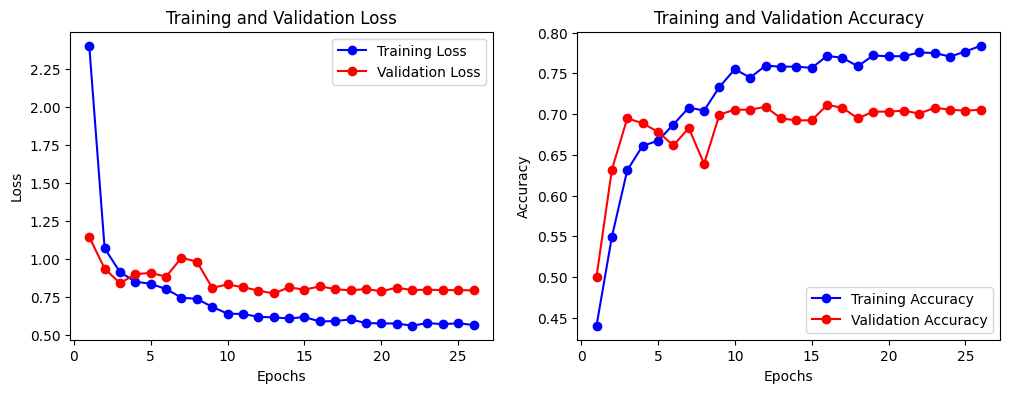

In [16]:
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(1, len(loss) + 1)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs, loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, accuracy, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()